### Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#unzip the dataset
!unzip "/content/drive/MyDrive/cnn/CNN_assignment (1).zip" > /dev/null

In [3]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
!ls

 drive	      'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [5]:
!ls  'Skin cancer ISIC The International Skin Imaging Collaboration'

Test  Train


In [6]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# Printing the count of images in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


In [8]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
#Use 80% of the images for training, and 20% for validation:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization

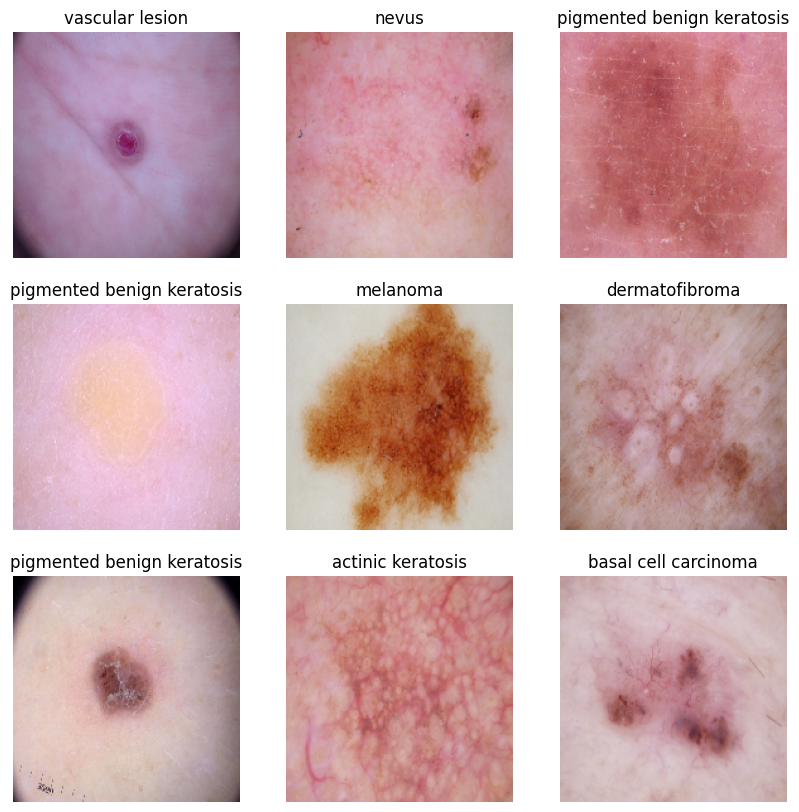

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Model Building

In [13]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#CNN Model Architecture

num_classes = 9

#Sequential allows you to create models layer-by-layer
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
#Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 27s 121ms/step - loss: 1.9769 - accuracy: 0.2595 - val_loss: 1.7642 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6660 - accuracy: 0.3923 - val_loss: 1.6155 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4781 - accuracy: 0.4738 - val_loss: 1.4245 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3490 - accuracy: 0.5246 - val_loss: 1.4100 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3304 - accuracy: 0.5424 - val_loss: 1.3551 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2658 - accuracy: 0.5463 - val_loss: 1.4159 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1677 - accuracy: 0.5837 - val_loss: 1.5495 - val_accuracy: 0.4653
Epoch 8/20
56/56 [====

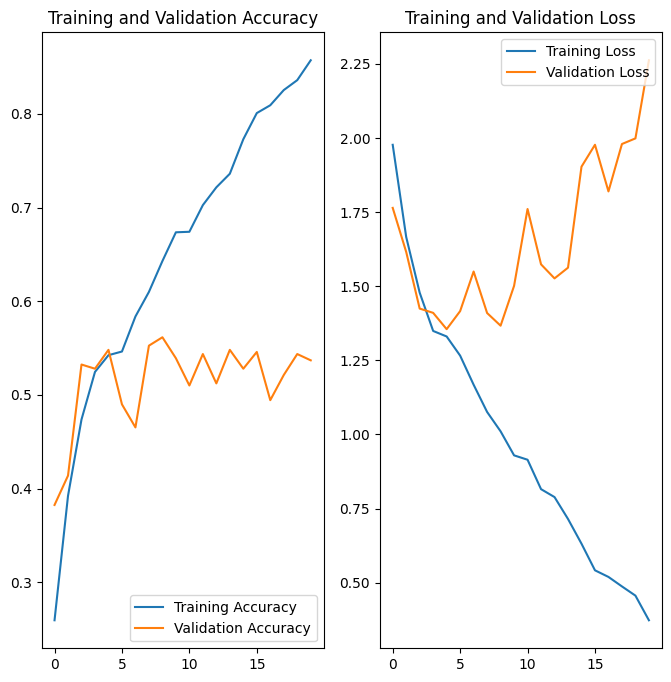

In [17]:
#Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy consistently increases over time in the plots, while the validation accuracy tends to plateau around 60% during the training process. Additionally, there is a noticeable gap between the training and validation accuracy, indicating the presence of overfitting.

In [18]:
#data augumentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

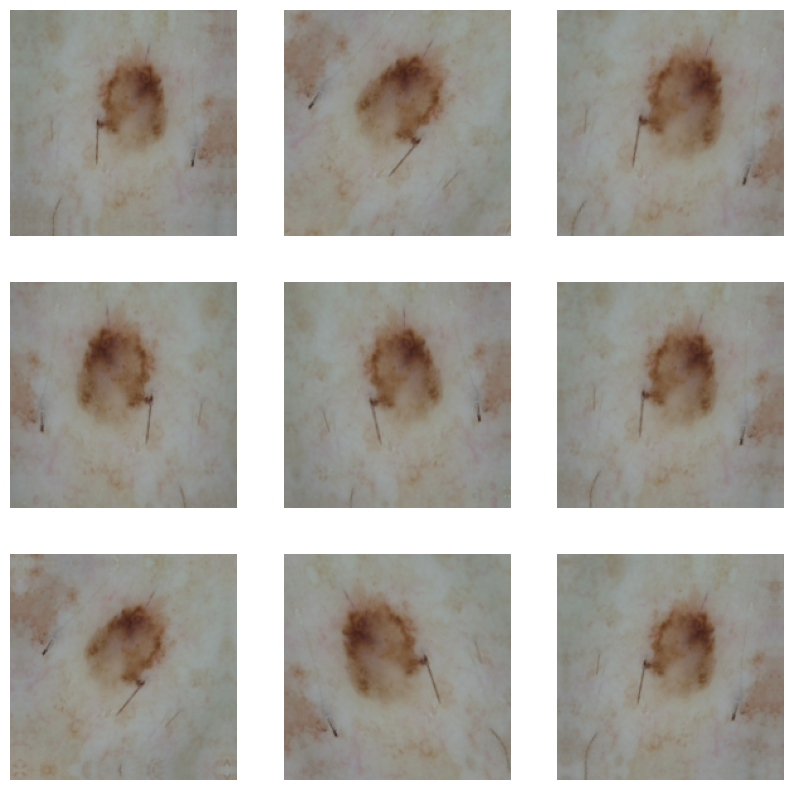

In [19]:
#visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the model, compile and train the model

In [20]:
#CNN Model Architecture

num_classes = 9

#Sequential allows you to create models layer-by-layer
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [21]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
#Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 30ms/step - loss: 1.9452 - accuracy: 0.2829 - val_loss: 1.7148 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6597 - accuracy: 0.4118 - val_loss: 1.6521 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4829 - accuracy: 0.4788 - val_loss: 1.4747 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3480 - accuracy: 0.5246 - val_loss: 1.3934 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2783 - accuracy: 0.5463 - val_loss: 1.4599 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2089 - accuracy: 0.5737 - val_loss: 1.3864 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.1166 - accuracy: 0.5971 - val_loss: 1.5488 - val_accuracy: 0.5034
Epoch 8/20
56

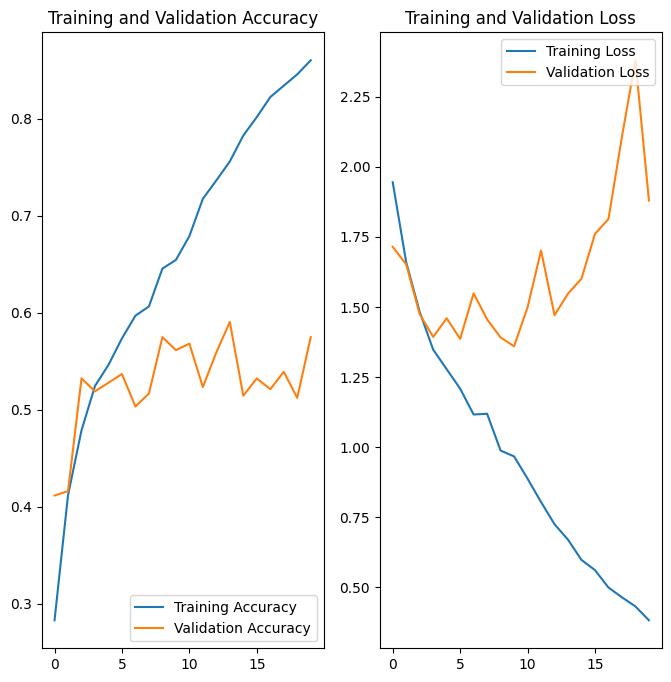

In [23]:
#Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With a training accuracy the model shows strong performance on the training data. However, the validation accuracy at around 50% suggests significant overfitting, indicating a lack of generalization to new data.

##Class Imbalance


Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
#class imbalance
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
3,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
4,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2235,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2236,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2237,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


Class=5, n=462 (20.634%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=0, n=114 (5.092%)


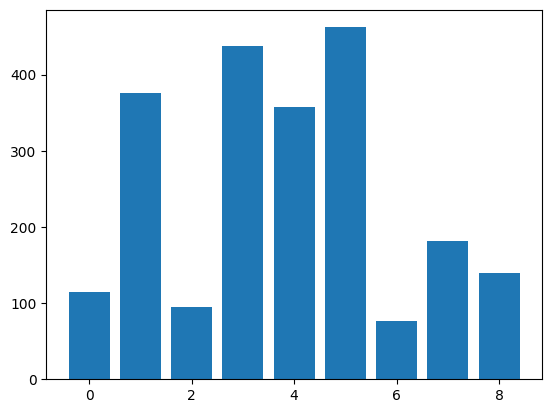

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

This class imbalance can potentially lead to challenges in training machine learning models, as they may struggle to learn and generalize effectively, particularly for the minority classes like Class 6 and Class 2. Addressing this imbalance through techniques such as oversampling, undersampling, or using appropriate evaluation metrics is crucial for achieving a balanced and accurate model.

## Rectify the class imbalance

There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

In [28]:
# We are adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B84CCD77A30>: 100%|██████████| 500/500 [00:18<00:00, 27.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B84CC3904C0>: 100%|██████████| 500/500 [00:18<00:00, 26.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B85844F3850>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B84CC391330>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7B84CCE54C40>: 100%|██████████| 500/500 [01:13<00:00,  6.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B84CC3F3F10>: 100%|██████████| 500/500 [00:15<00:00, 32.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B84CC392410>: 100%|██████████| 500/500 [00:35<00:00, 14.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B84CC40C580>: 100%|██████████| 500/500 [00:15<00:00, 32.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B85844F3940>: 100%|██████████| 500/500 [00:15<00:00, 31.45 Samples/s]


In [29]:
#Total count of augmented images.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [30]:
# The distribution of augmented data after adding new images to the original training data.
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
#New Class data count:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

<ipython-input-31-33331cfc7b00>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process

## Train the model on the data created using Augmentor

In [32]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [33]:
#Use 80% of the images for training, and 20% for validation:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Building

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
#CNN Model Architecture

num_classes = 9

#Sequential allows you to create models layer-by-layer
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 60% Fraction of the input units to drop.
model.add(layers.Dropout(0.6))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [37]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
#Train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 52s 93ms/step - loss: 1.9611 - accuracy: 0.2596 - val_loss: 1.5407 - val_accuracy: 0.4217
Epoch 2/30
169/169 [==============================] - 9s 54ms/step - loss: 1.4988 - accuracy: 0.4364 - val_loss: 1.3492 - val_accuracy: 0.5011
Epoch 3/30
169/169 [==============================] - 9s 53ms/step - loss: 1.2806 - accuracy: 0.5115 - val_loss: 1.2630 - val_accuracy: 0.5293
Epoch 4/30
169/169 [==============================] - 9s 54ms/step - loss: 1.1724 - accuracy: 0.5575 - val_loss: 1.1126 - val_accuracy: 0.5783
Epoch 5/30
169/169 [==============================] - 9s 55ms/step - loss: 1.0710 - accuracy: 0.6063 - val_loss: 1.1680 - val_accuracy: 0.5828
Epoch 6/30
169/169 [==============================] - 9s 53ms/step - loss: 0.9465 - accuracy: 0.6489 - val_loss: 1.0426 - val_accuracy: 0.6273
Epoch 7/30
169/169 [==============================] - 9s 54ms/step - loss: 0.8558 - accuracy: 0.6730 - val_loss: 0.8642 - val_accuracy: 0.6949
Epoch 8/3

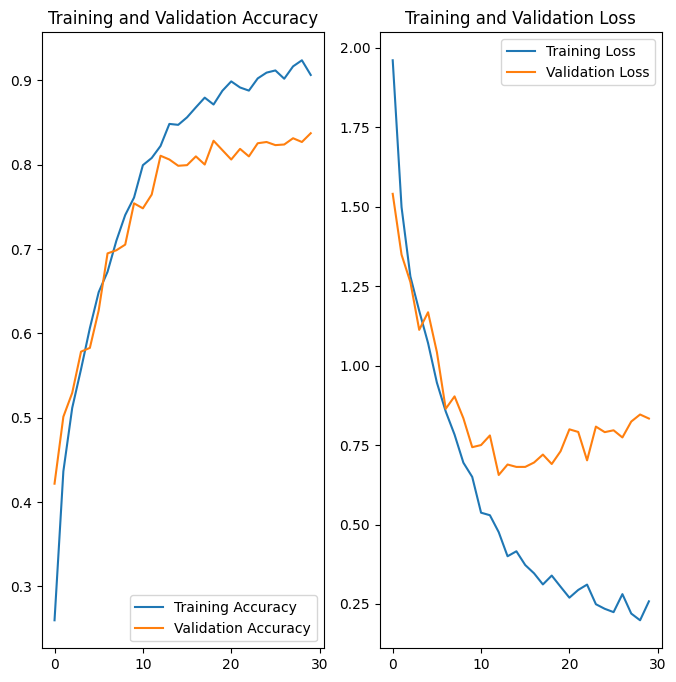

In [39]:
#Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy on training data has increased by using Augmentor library
The Model can be further improved by tuning the hyperparameter


## Model Prediction

1/1 [==============================] - 0s 211ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


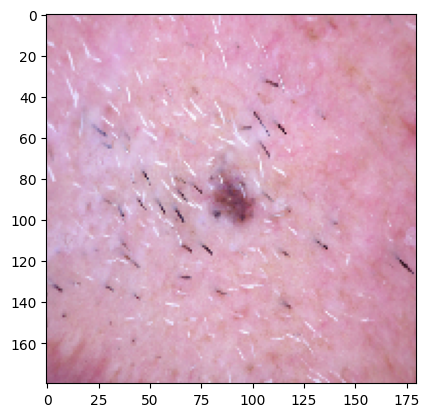

In [40]:
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )